Env of this notebook: jupyter triton with Kernel2

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import time

In [2]:
os.environ['TRANSFORMERS_OFFLINE']="1"

In [3]:
os.environ['TRANSFORMERS_CACHE'] = '/scratch/shareddata/dldata/huggingface-hub-cache/hub'

In [4]:
import torch
from trl import AutoModelForCausalLMWithValueHead, PPOConfig, PPOTrainer
from transformers import AutoTokenizer, AutoModelForCausalLM

## Load the model and initialize the trainer

In [5]:
# model_name = "meta-llama/Llama-2-7b-chat-hf"
model_name = "gpt2"

In [6]:
# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name,padding_side='left', device_map="cpu")
tokenizer.pad_token_id = tokenizer.eos_token_id

In [7]:
# Load the policy network
model = AutoModelForCausalLMWithValueHead.from_pretrained(model_name)



In [8]:
model

AutoModelForCausalLMWithValueHead(
  (pretrained_model): GPT2LMHeadModel(
    (transformer): GPT2Model(
      (wte): Embedding(50257, 768)
      (wpe): Embedding(1024, 768)
      (drop): Dropout(p=0.1, inplace=False)
      (h): ModuleList(
        (0-11): 12 x GPT2Block(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): GPT2Attention(
            (c_attn): Conv1D()
            (c_proj): Conv1D()
            (attn_dropout): Dropout(p=0.1, inplace=False)
            (resid_dropout): Dropout(p=0.1, inplace=False)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): GPT2MLP(
            (c_fc): Conv1D()
            (c_proj): Conv1D()
            (act): NewGELUActivation()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
      (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    )
    (lm_head): Linear(in_features=768, out_features=50257, bias=False)
  )
  (

**Original paper:** https://arxiv.org/pdf/1707.06347.pdf

**Diagram:** https://huggingface.co/blog/trl-peft

**Value head**:A concepts related to actor-critic methods in reinforcement learning.

- Definition: In RL, a value head is a component of a neural network that estimates the value of being in a certain state. This value is typically a prediction of the expected cumulative reward from that state onwards, under a certain policy.

- Actor-Critic Methods: Actor-critic methods are a class of algorithms in RL that use two models: an actor, which decides which action to take, and a critic, which evaluates the action. The actor is typically a policy network that outputs a probability distribution over actions, while the critic is a value network that estimates the value of the current state or the value of taking an action in the current state.

- Role in Language Models: In the context of large language models, a value head could be used to evaluate the potential "value" or usefulness of different continuations of a text sequence. For example, it might estimate the expected quality or relevance of a response given the current conversation context.

- Application to Language Models: In large language models, an actor-critic approach could be used to both generate text (actor) and evaluate the quality or appropriateness of the generated text (critic). The critic helps in refining the policy of the actor by providing feedback on its performance.

- Training and Feedback Loop: The actor is trained to maximize the expected reward, as predicted by the critic. The critic (value head), in turn, is trained to accurately predict the expected reward minimize the difference between its value predictions and the actual rewards received. This creates a feedback loop where both components improve over time, leading to more effective text generation.



In [9]:
model_ref = AutoModelForCausalLMWithValueHead.from_pretrained(model_name)

In [10]:
device = model.pretrained_model.device
device

device(type='cpu')

In [11]:
# initialize trainer
ppo_config = {"batch_size": 2}
config = PPOConfig(**ppo_config)
ppo_trainer = PPOTrainer(config, model, model_ref, tokenizer)
# ppo_trainer.accelerator.device
# ppo_trainer.current_device

Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


## Show generation

In [12]:
prompts = ['How do you like my new hair cut?',
           'Do you like Taylor Swift?'
          ]

In [14]:
inputs = tokenizer(prompts, padding=True,
                   truncation=True,
                   max_length=30, 
                   return_tensors="pt"
                  ).to(device)

# Generate outputs
generation_kwargs = {"min_length": -1, 
                     "top_k": 0.0, 
                     "top_p": 1.0, 
                     "do_sample": True, 
                     "pad_token_id": tokenizer.eos_token_id
                    }

outputs = model.generate(**inputs, **generation_kwargs)
    
# Decode the outputs
responds = tokenizer.batch_decode(outputs, skip_special_tokens=True)


responds

['How do you like my new hair cut?\n\nDid you consider starting a wig program now?',
 'Do you like Taylor Swift? / For Justin Bieber?\n\nJack Swagger/']

## Get rewards

In [28]:
# Use a bert model as the reward function
from transformers import pipeline

classifier = pipeline("text-classification", model="finiteautomata/bertweet-base-sentiment-analysis")

In [29]:
results = classifier(responds)
results

[{'label': 'NEU', 'score': 0.947227954864502},
 {'label': 'POS', 'score': 0.6566925048828125}]

In [16]:
rewards = []
for result in results:
    if result['label']=='POS':
        reward = result['score']
    else: reward = -result['score']
    rewards.append(reward)

rewards

[-0.7851606607437134, -0.5281864404678345]

## Prepare training tensors: inputs, outputs and rewards 

In [17]:
input_tensors = tokenizer(prompts, padding=True, truncation=True,\
                   max_length=30, return_tensors="pt")['input_ids'].to(device)
input_tensors = []
for prompt in prompts:
    input_ = tokenizer(prompt, padding=True, truncation=True,\
                   max_length=30, return_tensors="pt")['input_ids']
    input_tensors.append(input_.squeeze())

In [18]:
response_tensors = []
for input_tensor in input_tensors:
    response = ppo_trainer.generate(input_tensor, **generation_kwargs)
    response_tensors.append(response.squeeze())
response_tensors

[tensor([ 2437,   466,   345,   588,   616,   649,  4190,  2005,    30,  1400,
          1917,  3516,    13, 27522,   340,   373,  2495,  7721, 14930,   276]),
 tensor([ 5211,   345,   588,  8121, 15608,    30,  3914,  2488, 16783, 41909,
            65,  2792,   534, 10586,   290,   340,   481, 10648,   416, 14187])]

In [19]:
reward_tensors = []
for reward in rewards:
    reward_tensors.append(torch.tensor(reward)) 
reward_tensors

[tensor(-0.7852), tensor(-0.5282)]

## Train model with ppo

In [22]:
total_epochs = 10
policy_losses = []
for epoch in range(total_epochs):
    train_stats = ppo_trainer.step(input_tensors, response_tensors, reward_tensors)
    policy_losses.append(train_stats['ppo/loss/policy']) 

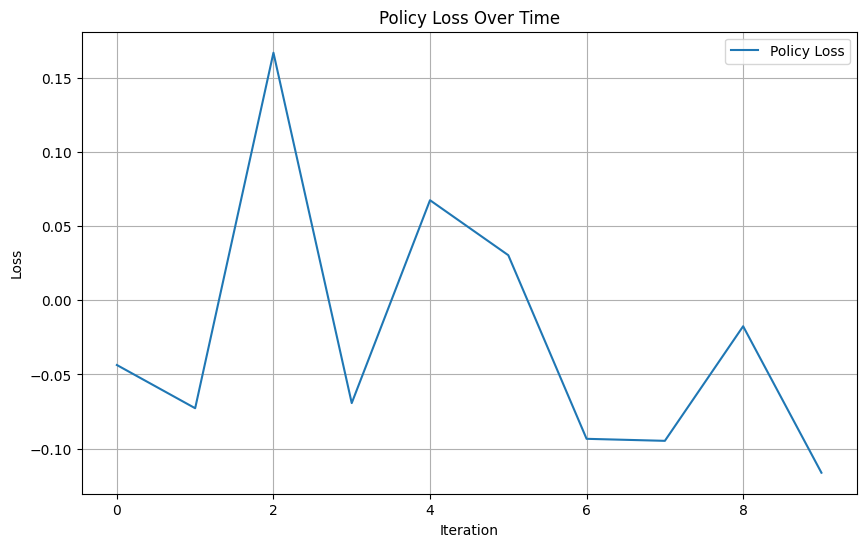

In [23]:
import matplotlib.pyplot as plt

## Visualizes the policy loss over time (or iterations).e
   
plt.figure(figsize=(10, 6))
plt.plot(policy_losses, label='Policy Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Policy Loss Over Time')
plt.legend()
plt.grid(True)
plt.show()